In [1]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import requests
from coordinate_scraper import CoordScraper

# Join Data 

In [2]:
scraped = pd.read_csv('./data/scraped_20220706.csv')

In [3]:
cities = ['amsterdam', 'amstelveen', 'diemen', 'zaandam', 'haarlem', 'weesp', 'ouderkerk-aan-de-amstel',
         'ouder-amstel','uithoorn','aalsmeer','haarlemmermeer',
         'duivendrecht','hoofddorp','nieuw-vennep','badhoevedorp',
         'ruigoord','zwanenburg','lijnen','de-liede']

In [4]:
rentkagg = pd.read_json('./data/properties.json',lines=True)

In [5]:
rentkagg = rentkagg[['areaSqm','city','furnish','latitude','longitude','postalCode','propertyType','rent','source','matchCapacity']]

In [6]:
rentkagg = rentkagg[rentkagg.city.str.lower().isin(cities)]

In [7]:
rentkagg = rentkagg.rename(columns={
    'areaSqm' : 'surface',
    'rent': 'price',
    'furnish': 'furnished',
    'postalCode': 'postcode',
    'propertyType': 'type',
    'matchCapacity': 'rooms'
})

In [8]:
rentkagg['postType'] = 'Rent'

In [9]:
buykagg = pd.read_csv('./data/HousingPrices-Amsterdam-August-2021.csv')

In [10]:
buykagg = buykagg.rename(columns={
    'Area' : 'surface',
    'Price': 'price',
    'Zip': 'postcode',
    'Room': 'rooms',
    'Lon': 'longitude',
    'Lat': 'latitude'
})

In [11]:
buykagg['source'] = 'Pararius'
buykagg['type'] = 'house'
buykagg['postType'] = 'Buy'
buykagg['city'] = 'amsterdam'
buykagg['furnished'] = None

In [12]:
buykagg.drop(columns=['Unnamed: 0','Address'],inplace=True)

In [13]:
data = pd.concat([scraped,rentkagg,buykagg]).reset_index(drop=True).drop_duplicates()

# Format Data

In [14]:
data['type'].unique()

array([' - Apartment ', ' - Room ', ' - Studio ', 'House', 'Appartment',
       'Apartment', 'Studio', 'Room', 'Appartement', 'Project:', 'Huis',
       ' - Anti-squat ', 'Anti-squat', 'Student residence', 'house'],
      dtype=object)

In [15]:
data['type'] = data['type'].str.replace(' - ','').str.strip().str.lower()
data['type'] = data['type'].replace('anti-squat','apartment')
data['type'] = data['type'].replace('student residence','apartment')
data['type'] = data['type'].replace('appartement','apartment')
data['type'] = data['type'].replace('appartment','apartment')
data['type'] = data['type'].replace('project:','apartment')
data['type'] = data['type'].replace('huis','house')

In [16]:
def format_postcode(x):
    x = x.split(' ')
    if len(x) > 1:
        x = ''.join(x[:2])
    else:
        x = x[0]
    if len(x) > 6:
        x = x[:4]
    if x[:4].isnumeric():
        return x
    else:
        return None

In [17]:
data['postcode'] = data['postcode'].apply(format_postcode)

In [18]:
def format_priceranges(x):
    if ' to ' in x:
        x = x.split('to')
        n1 = float(re.sub("[^\\d.]","",x[0]))
        n2 = float(re.sub("[^\\d.]","",x[1]))
        return str((n1+n2)/2)
    if ' - ' in x:
        x = x.split('-')
        n1 = float(re.sub("[^\\d.]","",x[0]))
        n2 = float(re.sub("[^\\d.]","",x[1]))
        return str((n1+n2)/2)
    else:
        return x

In [19]:
data['price'] = data['price'].astype('str').str.replace('.0','',regex=False).str.replace(',-','',regex=False).str.replace('.','',regex=False).str.replace('k.k.','',regex=False)

In [20]:
data['price'] = data['price'].apply(format_priceranges).str.replace("[^\\d.]","",regex=True).replace('',None).astype('float')

In [21]:
data = data.dropna(subset=['price','postcode'])

In [22]:
data = data[data['price'] > 100].reset_index(drop=True)

In [23]:
def format_surfranges(x):
    if ' - ' in x:
        x = x.split(' - ')
        n1 = float(re.sub("[^\\d.]","",x[0]))
        n2 = float(re.sub("[^\\d.]","",x[1]))
        return str((n1+n2)/2)
    else:
        return x

In [24]:
data['surface'] = data['surface'].astype('str').apply(format_surfranges).str.replace(',','').str.replace('m2','').str.replace('m²','').str.strip().astype(float)

In [25]:
data['rooms'] = data['rooms'].replace('Not important',None)

In [26]:
data['rooms'] = data['rooms'].str.replace("[^\\d]","",regex=True).astype('float')

In [27]:
type_medians = data.groupby('type')['rooms'].median()
def impute_rooms(x):
    if pd.isna(x.rooms):
        return type_medians[x.type]
    else:
        return x.rooms

In [28]:
data['rooms'] = data.apply(impute_rooms,axis=1)

In [29]:
data = data.dropna(subset=['surface','price'])

In [30]:
data['source'] = data['source'].str.lower()
data['city'] = data['city'].str.lower()

In [31]:
data = data.drop(columns=['furnished'])

In [32]:
coordscraper = CoordScraper()

In [33]:
coordscraper.known_coords

,postcode,latitude,longitude
0,1103SE,52.322157,4.981185
1,1103TV,52.322841,4.975622
2,1073ST,52.352476,4.902164
3,1106AG,52.297942,4.974682
4,1065LW,52.356471,4.820362
...,...,...,...
9072,1076KZ,52.343244,4.860607
9073,1060TB,52.344678,4.790015
9074,1082GC,52.331144,4.879818
9075,1509AK,52.469413,4.827703


In [34]:
data['latitude'] = np.nan
data['longitude'] = np.nan

In [35]:
coordmap = coordscraper.known_coords.copy()
coordmap.set_index('postcode',inplace=True)

In [36]:
data.loc[data.latitude.isna(),'latitude'] = data[data.latitude.isna()].postcode.map(dict(coordmap.latitude))
data.loc[data.longitude.isna(),'longitude'] = data[data.longitude.isna()].postcode.map(dict(coordmap.longitude))

In [37]:
coordscraper.get_coordinates(data[data['latitude'].isna()][['postcode','city','latitude','longitude']].drop_duplicates())

  0%|          | 0/85 [00:00<?, ?it/s]

In [38]:
coordscraper.new_coords

,postcode,latitude,longitude
0,1054EL,52.360880,4.864384
1,1092XR,52.354181,4.922589
2,1052CN,52.381292,4.878980
3,1093XR,52.361499,4.927447
4,1053EC,52.367112,4.871263
...,...,...,...
68,1064CT,52.372323,4.829355
69,2134EL,52.313877,4.651585
70,2132WG,52.298473,4.688766
71,2131XT,52.310540,4.687971


In [39]:
coordscraper.save_new_coords()

In [40]:
coordmap = coordscraper.known_coords.copy()

In [41]:
coordmap.set_index('postcode',inplace=True)

In [42]:
data.loc[data.latitude.isna(),'latitude'] = data[data.latitude.isna()].postcode.map(dict(coordmap.latitude))
data.loc[data.longitude.isna(),'longitude'] = data[data.longitude.isna()].postcode.map(dict(coordmap.longitude))

In [43]:
data = data.drop_duplicates()

In [44]:
data.isna().sum()

source       0
city         0
postcode     0
type         0
price        0
surface      0
rooms        0
latitude     0
longitude    0
postType     0
dtype: int64

In [45]:
data.to_csv('prepared_amsterdam_rent.csv',index=False)

In [46]:
data = pd.read_csv('prepared_amsterdam_rent.csv')

<AxesSubplot:xlabel='longitude', ylabel='price'>

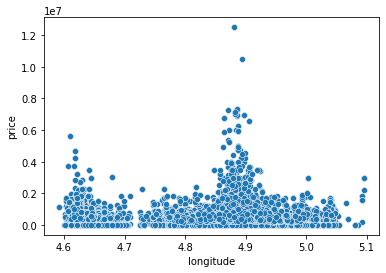

In [47]:
sns.scatterplot(data=data,x='longitude',y='price')

<AxesSubplot:xlabel='latitude', ylabel='price'>

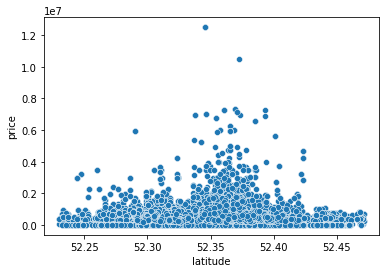

In [48]:
sns.scatterplot(data=data,x='latitude',y='price')

<AxesSubplot:xlabel='rooms', ylabel='price'>

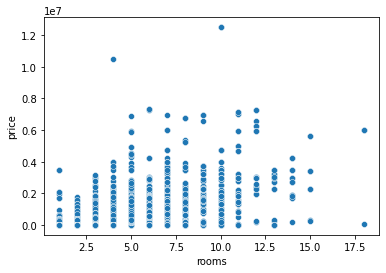

In [49]:
sns.scatterplot(data=data,x='rooms',y='price')

In [50]:
data['pps'] = data['price']/data['surface']

<AxesSubplot:xlabel='type', ylabel='pps'>

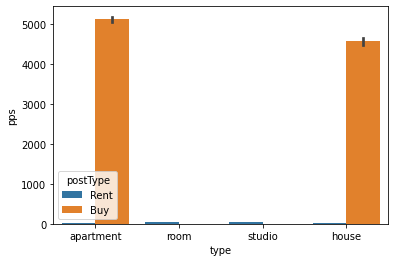

In [51]:
sns.barplot(data=data,x='type',y='pps',hue='postType')

<AxesSubplot:xlabel='surface', ylabel='price'>

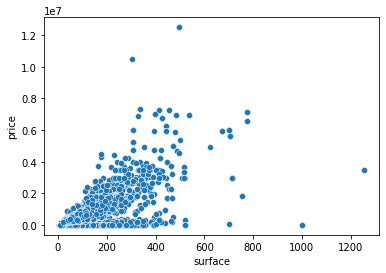

In [52]:
sns.scatterplot(data=data,x='surface',y='price')

In [53]:
data['longcat'] = pd.cut(data['longitude'],50,labels=list(range(50))).astype('int')
data['latcat'] = pd.cut(data['latitude'],50,labels=list(range(50))).astype('int')

In [54]:
data['ppaCatPerct'] = None

In [56]:
ranks = {}
for t in data.type.unique():
    for pt in data.postType.unique():
        df = data[(data['type']==t)&(data['postType']==pt)]
        if len(df) > 0:
            ranks[(t,pt)] = pd.cut(df['pps'],50,labels=list(range(50)))

In [57]:
ranks = {}
for t in data.type.unique():
    for pt in data.postType.unique():
        df = data[(data['type']==t)&(data['postType']==pt)]
        if len(df) > 0:
            ranks[(t,pt)] = df['pps'].rank()
            ranks[(t,pt)]=(ranks[(t,pt)]-ranks[(t,pt)].min())/(ranks[(t,pt)].max()-ranks[(t,pt)].min())

In [58]:
for k in ranks:
    data.loc[ranks[k].index,'ppaCatPerct'] = ranks[k]

In [59]:
data.groupby(['type','postType'])['ppaCatPerct'].mean()

type       postType
apartment  Buy         0.5
           Rent        0.5
house      Buy         0.5
           Rent        0.5
room       Rent        0.5
studio     Rent        0.5
Name: ppaCatPerct, dtype: float64

In [63]:
data.groupby(['latcat','longcat'])[['latitude','longitude']].mean()

latitude  longitude
latcat longcat                      
0      21       52.233117   4.809142
       22       52.232121   4.820126
       23       52.232931   4.830306
1      21       52.236857   4.808004
       23       52.236794   4.825928
...                   ...        ...
48     22       52.461840   4.814057
       23       52.465973   4.829970
49     23       52.469089   4.830481
       24       52.469298   4.838372
       25       52.469801   4.845641

[723 rows x 2 columns]

<AxesSubplot:xlabel='longcat', ylabel='latcat'>

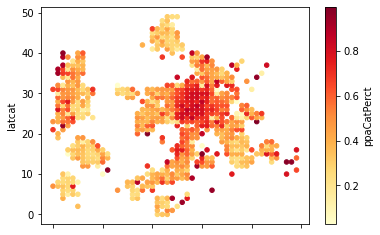

In [60]:
data.groupby(['latcat','longcat'])['ppaCatPerct'].median().reset_index().dropna().plot(x='longcat',y='latcat',kind='scatter',c='ppaCatPerct',cmap='YlOrRd')

<AxesSubplot:xlabel='longcat', ylabel='latcat'>

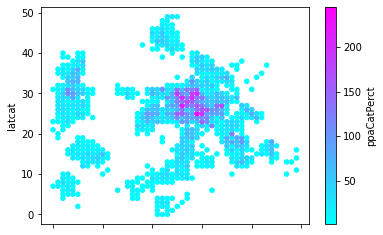

In [61]:
data.groupby(['latcat','longcat'])['ppaCatPerct'].count().reset_index().dropna().plot(x='longcat',y='latcat',kind='scatter',c='ppaCatPerct',cmap='cool')

<AxesSubplot:xlabel='type', ylabel='ppaCatPerct'>

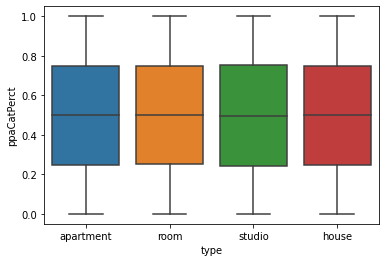

In [712]:
sns.boxplot(data=data, x='type', y='ppaCatPerct')

<AxesSubplot:xlabel='postType', ylabel='ppaCatPerct'>

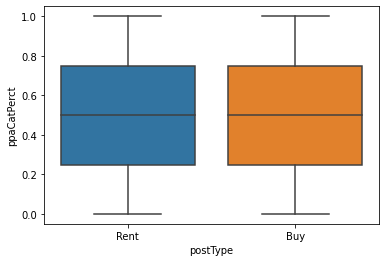

In [713]:
sns.boxplot(data=data, x='postType', y='ppaCatPerct')

<AxesSubplot:xlabel='ppaCatPerct', ylabel='Count'>

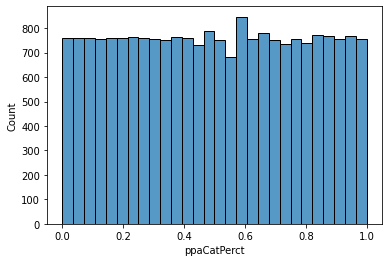

In [715]:
sns.histplot(data=data, x='ppaCatPerct')

In [184]:
data['postcode_num'] = data['postcode'].str.slice(0,4)

In [237]:
data['price_p_area'] = data['price']/data['surface']

,source,city,postcode,type,price,surface,rooms,furnished,latitude,longitude,postType
0,Kamernet,amsterdam,1103SE,apartment,"€ 3120,-",120 m2,NaN,Unfurnished,52.322159,4.981188,NaN
1,Kamernet,amsterdam,1103TV,room,"€ 675,-",12 m2,NaN,Unfurnished,52.322843,4.975625,NaN
2,Kamernet,amsterdam,1073ST,apartment,"€ 1495,-",45 m2,- 1 bedroom,Furnished,52.352478,4.902167,NaN
3,Kamernet,amsterdam,1106AG,room,"€ 425,-",10 m2,NaN,Furnished,52.297944,4.974685,NaN
4,Kamernet,amsterdam,1065LW,apartment,"€ 1100,- Utilities incl.",55 m2,NaN,Furnished,52.356473,4.820365,NaN
...,...,...,...,...,...,...,...,...,...,...,...
13043,Pararius,amsterdam,1097 AE,house,750000.0,117,1,None,52.354173,4.927757,Buy
13044,Pararius,amsterdam,1033 CP,house,350000.0,72,3,None,52.414587,4.890612,Buy
13045,Pararius,amsterdam,1058 AK,house,350000.0,51,3,None,52.363256,4.856935,Buy
13046,Pararius,amsterdam,1095 MB,house,599000.0,113,4,None,52.375268,4.965731,Buy


<AxesSubplot:xlabel='longitude', ylabel='latitude'>

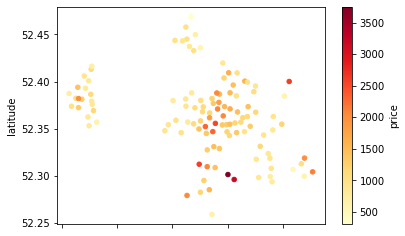

In [190]:
data.groupby('postcode_num')[['price','latitude','longitude']].mean().reset_index().plot(x='longitude',y='latitude',c='price',kind='scatter',cmap='YlOrRd')

In [192]:
data.groupby('postcode_num')[['price','latitude','longitude']].count().sort_values('price')

,price,latitude,longitude
postcode_num,,,
1384,1,1,1
1509,1,1,1
1028,1,1,1
1189,1,1,1
2019,2,2,2
...,...,...,...
1078,195,195,195
1012,197,197,197
1017,200,200,200


In [65]:
import geopandas as gpd

In [77]:
import sqlite3

In [78]:
conn = sqlite3.connect('./data/WijkBuurtkaart_2021_v1.gpkg')

In [79]:
cursor = conn.cursor()

In [88]:
cursor.execute("select name from sqlite_schema where type='table' and name not like 'sqlite_%';")

In [90]:
result = cursor.fetchall()

In [91]:
result

[('gpkg_spatial_ref_sys',),
 ('gpkg_contents',),
 ('gpkg_ogr_contents',),
 ('gpkg_geometry_columns',),
 ('gpkg_tile_matrix_set',),
 ('gpkg_tile_matrix',),
 ('gemeenten2021',),
 ('gpkg_extensions',),
 ('rtree_gemeenten2021_geom',),
 ('rtree_gemeenten2021_geom_rowid',),
 ('rtree_gemeenten2021_geom_node',),
 ('rtree_gemeenten2021_geom_parent',),
 ('cbs_wijken_2021',),
 ('rtree_cbs_wijken_2021_geom',),
 ('rtree_cbs_wijken_2021_geom_rowid',),
 ('rtree_cbs_wijken_2021_geom_node',),
 ('rtree_cbs_wijken_2021_geom_parent',),
 ('cbs_buurten_2021',),
 ('rtree_cbs_buurten_2021_geom',),
 ('rtree_cbs_buurten_2021_geom_rowid',),
 ('rtree_cbs_buurten_2021_geom_node',),
 ('rtree_cbs_buurten_2021_geom_parent',)]

In [98]:
buurten = gpd.read_file('./data/WijkBuurtkaart_2021_v1.gpkg',layer='cbs_buurten_2021')

In [103]:
wijken = gpd.read_file('./data/WijkBuurtkaart_2021_v1.gpkg',layer='cbs_wijken_2021')

In [361]:
gpd.read_file('./data/WijkBuurtkaart_2021_v1.gpkg',layer='gemeenten2021')

,gemeentecode,gemeentenaam,water,omgevingsadressendichtheid,stedelijkheid_adressen_per_km2,bevolkingsdichtheid_inwoners_per_km2,aantal_inwoners,mannen,vrouwen,percentage_personen_0_tot_15_jaar,...,percentage_uit_nederlandse_antillen_en_aruba,percentage_uit_suriname,percentage_uit_turkije,percentage_overige_nietwestersemigratieachtergrond,oppervlakte_totaal_in_ha,oppervlakte_land_in_ha,oppervlakte_water_in_ha,jaarstatcode,jaar,geometry
0,GM0034,Almere,JA,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,...,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,2021GM0034,2021,"MULTIPOLYGON (((150213.998 479503.726, 150087...."
1,GM0050,Zeewolde,JA,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,...,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,2021GM0050,2021,"MULTIPOLYGON (((170588.413 486792.192, 170570...."
2,GM0060,Ameland,JA,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,...,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,2021GM0060,2021,"MULTIPOLYGON (((196000.000 610000.000, 196000...."
3,GM0072,Harlingen,JA,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,...,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,2021GM0072,2021,"MULTIPOLYGON (((158392.775 580357.500, 158387...."
4,GM0088,Schiermonnikoog,JA,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,...,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,2021GM0088,2021,"MULTIPOLYGON (((219000.000 616567.418, 219000...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,GM1966,Het Hogeland,NEE,414,5,99,47834,24052,23782,15,...,0,0,0,3,90308,48249,42059,2021GM1966,2021,"MULTIPOLYGON (((217037.735 601967.991, 217043...."
431,GM1969,Westerkwartier,NEE,476,5,176,63678,32034,31644,17,...,0,0,0,3,36887,36269,618,2021GM1969,2021,"MULTIPOLYGON (((215186.661 595044.495, 215190...."
432,GM1970,Noardeast-Fryslân,NEE,463,5,120,45481,22879,22602,17,...,0,0,0,2,51645,37783,13862,2021GM1970,2021,"MULTIPOLYGON (((207769.575 603284.528, 207773...."
433,GM1978,Molenlanden,NEE,393,5,243,44130,22317,21813,18,...,0,0,0,2,19158,18173,986,2021GM1978,2021,"MULTIPOLYGON (((123569.533 440132.167, 123576...."


In [104]:
buurten[buurten['gemeentenaam']=='Haarlem']

,buurtcode,buurtnaam,wijkcode,gemeentecode,gemeentenaam,indelingswijziging_wijken_en_buurten,water,meest_voorkomende_postcode,dekkingspercentage,omgevingsadressendichtheid,...,percentage_uit_nederlandse_antillen_en_aruba,percentage_uit_suriname,percentage_uit_turkije,percentage_overige_nietwestersemigratieachtergrond,oppervlakte_totaal_in_ha,oppervlakte_land_in_ha,oppervlakte_water_in_ha,jaarstatcode,jaar,geometry
4809,BU03920101,Stationsbuurt,WK039201,GM0392,Haarlem,1,NEE,2011,1,5056,...,0,1,1,9,51,46,5,2021BU03920101,2021,"MULTIPOLYGON (((103889.258 489415.316, 103917...."
4810,BU03920102,Binnenstad,WK039201,GM0392,Haarlem,1,NEE,2011,1,5838,...,0,1,1,8,27,26,1,2021BU03920102,2021,"MULTIPOLYGON (((103862.446 488835.233, 103859...."
4811,BU03920103,Bakenes,WK039201,GM0392,Haarlem,1,NEE,2011,1,5561,...,0,1,1,7,25,23,2,2021BU03920103,2021,"MULTIPOLYGON (((104227.761 488779.744, 104286...."
4812,BU03920104,Burgwal,WK039201,GM0392,Haarlem,1,NEE,2011,1,5578,...,0,1,2,6,21,18,3,2021BU03920104,2021,"MULTIPOLYGON (((104320.656 488719.022, 104381...."
4813,BU03920105,Vijfhoek,WK039201,GM0392,Haarlem,1,NEE,2011,1,5589,...,0,1,1,7,25,24,1,2021BU03920105,2021,"MULTIPOLYGON (((103414.654 488532.250, 103437...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4915,BU03922103,Nobelprijsbuurt,WK039221,GM0392,Haarlem,1,NEE,2037,1,2789,...,0,2,14,13,24,24,0,2021BU03922103,2021,"MULTIPOLYGON (((105824.295 486100.323, 105840...."
4916,BU03922104,Poelpolder-zuid,WK039221,GM0392,Haarlem,1,NEE,2037,1,1548,...,-99999999,-99999999,-99999999,-99999999,47,42,5,2021BU03922104,2021,"MULTIPOLYGON (((106011.254 486097.833, 106066...."
4917,BU03922105,Archimedesbuurt,WK039221,GM0392,Haarlem,1,NEE,2037,1,3614,...,0,3,14,18,16,16,0,2021BU03922105,2021,"MULTIPOLYGON (((105527.148 485752.969, 105696...."
4918,BU03922106,Erasmusbuurt,WK039221,GM0392,Haarlem,1,NEE,2037,2,3152,...,0,3,10,18,20,20,0,2021BU03922106,2021,"MULTIPOLYGON (((105769.564 485484.581, 105781...."


In [108]:
wijken[wijken['gemeentenaam']=='Diemen']

,wijkcode,wijknaam,gemeentecode,gemeentenaam,indelingswijziging_wijken_en_buurten,water,omgevingsadressendichtheid,stedelijkheid_adressen_per_km2,bevolkingsdichtheid_inwoners_per_km2,aantal_inwoners,...,percentage_uit_nederlandse_antillen_en_aruba,percentage_uit_suriname,percentage_uit_turkije,percentage_overige_nietwestersemigratieachtergrond,oppervlakte_totaal_in_ha,oppervlakte_land_in_ha,oppervlakte_water_in_ha,jaarstatcode,jaar,geometry
26,WK038499,,GM0384,Diemen,-99999999,JA,-99999999,-99999999,-99999999,-99999999,...,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,-99999999,2021WK038499,2021,"MULTIPOLYGON (((129707.725 484199.703, 129713...."
1037,WK038401,Diemen Noord,GM0384,Diemen,1,NEE,1289,3,5148,6725,...,0,9,4,11,145,131,15,2021WK038401,2021,"MULTIPOLYGON (((126550.109 485437.801, 126590...."
1038,WK038402,Diemen Centrum,GM0384,Diemen,1,NEE,2787,1,5496,10155,...,0,6,2,16,186,185,2,2021WK038402,2021,"MULTIPOLYGON (((127558.469 483706.997, 127630...."
1039,WK038403,Diemen Zuid,GM0384,Diemen,1,NEE,3434,1,6958,7470,...,0,9,4,14,112,107,4,2021WK038403,2021,"MULTIPOLYGON (((125542.129 483557.453, 125916...."
1040,WK038404,Bergwijkpark,GM0384,Diemen,1,NEE,3962,1,-99999999,0,...,-99999999,-99999999,-99999999,-99999999,21,21,0,2021WK038404,2021,"MULTIPOLYGON (((125437.747 482292.417, 125437...."
1041,WK038405,Holland Park,GM0384,Diemen,1,NEE,3715,1,9472,4590,...,2,8,2,27,48,48,0,2021WK038405,2021,"MULTIPOLYGON (((126297.418 482421.131, 126603...."
1042,WK038406,Bedrijventerreinen,GM0384,Diemen,1,NEE,2410,2,70,55,...,-99999999,-99999999,-99999999,-99999999,81,79,2,2021WK038406,2021,"MULTIPOLYGON (((126367.279 483187.924, 126934...."
1043,WK038407,Plantage de Sniep,GM0384,Diemen,1,NEE,1910,2,5015,2165,...,1,11,3,10,45,43,2,2021WK038407,2021,"MULTIPOLYGON (((126937.808 482780.651, 126934...."
1044,WK038408,Buitengebied,GM0384,Diemen,1,NEE,558,4,27,160,...,0,6,0,2,654,585,68,2021WK038408,2021,"MULTIPOLYGON (((130693.744 484729.154, 130686...."
